<a href="https://colab.research.google.com/github/sokrypton/algosb_2021/blob/main/msa_transformer_hypothesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import jax.numpy as jnp # numpy on steroids
import string
import matplotlib.pyplot as plt

In [2]:
def con_auc(true, pred, mask=None, thresh=0.01):
  '''compute agreement between predicted and measured contact map'''
  if mask is not None:
    idx = mask.sum(-1) > 0
    true = true[idx,:][:,idx]
    pred = pred[idx,:][:,idx]
  eval_idx = np.triu_indices_from(true, 6)
  pred_, true_ = pred[eval_idx], true[eval_idx] 
  L = (np.linspace(0.1,1.0,10)*len(true)).astype("int")
  sort_idx = np.argsort(pred_)[::-1]
  acc = [(true_[sort_idx[:l]] > thresh).mean() for l in L]
  return np.mean(acc)

def get_contacts(cov,A=21,do_apc=True):
  LA = cov.shape[0]
  L = LA//A
  cov = cov.reshape(L,A,L,A)[:,:20,:,:20]
  raw = np.sqrt(np.square(cov).sum((1,3)))
  np.fill_diagonal(raw,0)
  if do_apc:
    ap = raw.sum(0)
    apc = raw - (ap[:,None] * ap[None,:])/ap.sum()
    np.fill_diagonal(apc,0)
    return apc
  else:
    return raw

In [3]:
%%bash 
wget -nc -q https://github.com/sokrypton/seqmodels/raw/master/data.pickle.npy.gz
gunzip data.pickle.npy.gz

In [4]:
data = list(np.load("data.pickle.npy",allow_pickle=True))
a = data[0]

In [5]:
# baseline
msa = np.eye(21)[a["x"]]
msa = msa.reshape(msa.shape[0],-1)
cov = jnp.cov(msa.T)
inv_cov = jnp.linalg.inv(cov + 4.5/np.sqrt(msa.shape[0]) * np.eye(cov.shape[0]))
contacts = get_contacts(inv_cov)
auc_ic = con_auc(a["x_true"],contacts,a["x_mask"])
auc_ic

0.7557726113583009

In [7]:
np.random.seed(0)
msa = np.eye(21)[a["x"]]
N,L,A = msa.shape

rep = msa.reshape(N,-1)
rep = rep - rep.mean(0)

contacts = get_contacts(jnp.cov(rep.T))
auc = con_auc(a["x_true"],contacts,a["x_mask"])
for i in range(64):
  for n in [1]:
    # [0,1] = [col covariance (N,N), row covariance (LA,LA)]
    if n == 0: q = k = v = rep
    if n == 1: q = k = v = rep.T

    # estimate low-rank attention
    cov = (q @ k.T)/q.shape[0]
    tmp = np.random.normal(size=(q.shape[0],1))
    for _ in range(1): # power iteration
      tmp = cov @ tmp
      tmp /= jnp.sqrt(jnp.square(tmp).sum())
    att = tmp @ tmp.T

    rep_update = att @ v

    # "add" (aka. skip connection)
    if n == 0: rep -= 0.5 * rep_update
    if n == 1: rep -= 0.5 * rep_update.T

    contacts = get_contacts(jnp.cov(rep.T))
    auc = con_auc(a["x_true"],contacts,a["x_mask"])
    print(i,n,auc)


0 1 0.39877045919600446
1 1 0.39675556059502537
2 1 0.4037211568954815
3 1 0.3995953591980369
4 1 0.39769067946022896
5 1 0.4204532953188022
6 1 0.40552012453258823
7 1 0.41316353452371174
8 1 0.41016793464589896
9 1 0.42011726883855954
10 1 0.4310250085368731
11 1 0.5166454253387058
12 1 0.5193453571613333
13 1 0.5995365467746293
14 1 0.5977187594274618
15 1 0.6066358117945203
16 1 0.5986810243523264
17 1 0.6008389371845427
18 1 0.6044795726496359
19 1 0.6042372645209241
20 1 0.6229340766789664
21 1 0.6183437852010147
22 1 0.615580440845795
23 1 0.6377875542637353
24 1 0.6417950287698344
25 1 0.648836634505954
26 1 0.6573218305474801
27 1 0.656362037907064
28 1 0.6580793671418874
29 1 0.6656720671938628
30 1 0.66195720299796
31 1 0.6581603139645761
32 1 0.6596207828369917
33 1 0.6637066846148676
34 1 0.6464344754790803
35 1 0.6441748261672359
36 1 0.6565582643636821
37 1 0.6540146114073857
38 1 0.6587891581601871
39 1 0.6536759194250956
40 1 0.6499044213910271
41 1 0.6374233284550797


In [10]:
%%time
np.random.seed(0)
msa = np.eye(21)[a["x"]]
N,L,A = msa.shape

rep = msa.reshape(N,-1)
rep = rep - rep.mean(0)

contacts = get_contacts(jnp.cov(rep.T))
auc = [con_auc(a["x_true"],contacts,a["x_mask"])]
print(0,auc[-1])
for i in range(1000):
  if (i+1) % 100 == 0: print(i+1,auc[-1])
  for n in [1]:
    # [0,1] = [col covariance (N,N), row covariance (LA,LA)]
    if n == 0: q = k = v = rep
    if n == 1: q = k = v = rep.T

    # estimate low-rank attention
    cov = (q @ k.T)/q.shape[0]
    tmp = np.random.normal(size=(q.shape[0],1))
    for _ in range(1): # power iteration
      tmp = cov @ tmp
      tmp /= jnp.sqrt(jnp.square(tmp).sum())
    att = tmp @ tmp.T

    rep_update = att @ v

    # "add" (aka. skip connection)
    if n == 0: rep -= 0.1 * rep_update
    if n == 1: rep -= 0.1 * rep_update.T

    contacts = get_contacts(jnp.cov(rep.T))
    auc.append(con_auc(a["x_true"],contacts,a["x_mask"]))

0 0.4021492752427305
100 0.617882560375945
200 0.67672966730277
300 0.7091930842396642
400 0.7132778062879488
500 0.7167428448146548
600 0.7336470426612058
700 0.7398184751036339
800 0.7263152475281092
900 0.7313038066691336
1000 0.7448871352037669
CPU times: user 1min 2s, sys: 2.71 s, total: 1min 5s
Wall time: 1min 3s


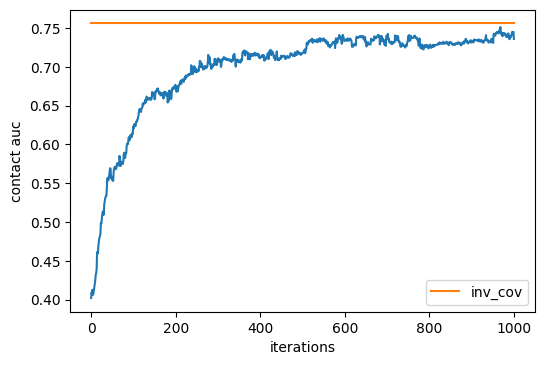

In [11]:
plt.figure(dpi=100)
plt.plot(auc)
plt.plot([0,1000],[auc_ic,auc_ic],label="inv_cov")
plt.xlabel("iterations")
plt.ylabel("contact auc")
plt.legend()

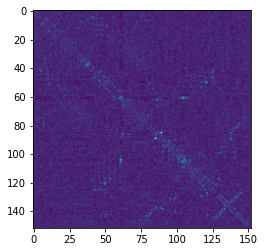

In [21]:
plt.imshow(get_contacts(jnp.cov(rep.T)))

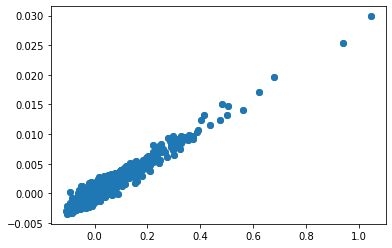

In [22]:
plt.scatter(get_contacts(inv_cov),get_contacts(jnp.cov(rep.T)))